In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime

import regionmask
import regionmask.defined_regions as rm

%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gp
import cartopy
import cartopy.crs as ccrs
from tqdm import tqdm  # Fancy progress bars for our loops!

# Utility functions for stream-lining analysis
from utils import *

In [3]:
all_provinces = regionmask.defined_regions.natural_earth.states_provinces_10
all_provinces_names = [province if province is not None else 'None' for province in all_provinces.names]

## Mainland China

In [4]:
df = load_jhu_df()
df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key
0,Hubei,Mainland China,1/24/20 17:00,549.0,24.0,31.0,01-24-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Guangdong,Mainland China,1/24/20 17:00,53.0,NaN,2.0,01-24-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Zhejiang,Mainland China,1/24/20 17:00,43.0,NaN,1.0,01-24-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Beijing,Mainland China,1/24/20 17:00,36.0,NaN,1.0,01-24-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chongqing,Mainland China,1/24/20 17:00,27.0,NaN,NaN,01-24-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['Xinjiang', 'Gansu', 'Yunnan', 'Heilongjiang', 'Jilin', 'Liaoning', 'Guangxi', 'Guangdong', 'Hainan', 'Fujian', 'Zhejiang', 'Shanghai', 'Jiangsu', 'Shandong', 'Hebei', 'Tianjin', 'Beijing', 'Sichuan', 'Chongqing', 'Guizhou', 'Hunan', 'Ningxia', 'Shaanxi', 'Qinghai', 'Shanxi', 'Jiangxi', 'Henan', 'Hubei', 'Anhui']


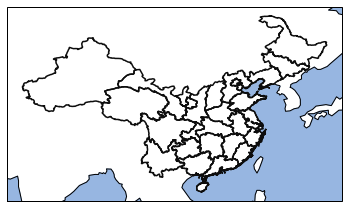

In [5]:
country = 'Mainland China'
cdf = df[df['Country/Region'] == country]

province_names = cdf['Province/State'].unique()
province_names = [province for province in all_provinces.names if province in province_names] # intersection of both data sets

provinces = all_provinces[province_names]
print(provinces.names)
provinces.plot(add_label=False);

In [6]:
ds = xr.open_dataset('../data/interim/daily_environmental.nc').isel(expver=1)
provinces_mask = provinces.mask(ds['longitude'], ds['latitude'], wrap_lon=True)
provinces_ma = np.ma.masked_invalid(provinces_mask)

In [7]:
varnames = ['t2m', 'q2m', 'sp', 'tp', 'uvb', 'ssrd']
index = 0

country_list = []
province_list = []
date_list = []
variable_list = [[]]
confirmed_list = []
recovered_list = []
deaths_list = []

for v in range(len(varnames)-1):
    variable_list.append([])

for province in tqdm(provinces.names):
    for v, varname in enumerate(varnames):
        pmean = ds[varname].where(provinces_ma == provinces[province].number).mean(dim=['latitude', 'longitude']).compute()
        for date in ds['time']:
            variable_list[v].append(pmean.sel(time=date).values)
            if v==0:
                country_list.append(country)
                province_list.append(province)
                date_list.append(date.values)
                
                idx = (
                    (cdf['date'].astype("datetime64") == date.values) &
                    (cdf['Province/State'] == province)
                )
                if idx.any():
                    confirmed_list.append(cdf[idx]['Confirmed'].values.item())
                    deaths_list.append(cdf[idx]['Deaths'].values.item())
                    recovered_list.append(cdf[idx]['Recovered'].values.item())
                else:
                    confirmed_list.append(np.nan)
                    deaths_list.append(np.nan)
                    recovered_list.append(np.nan)

  0%|          | 0/29 [00:00<?, ?it/s]/home/hdrake/.conda/envs/covid-weather/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
100%|██████████| 29/29 [06:11<00:00, 12.80s/it]


In [8]:
edf = pd.DataFrame({
    "Country/Region": country_list,
    "Province/State": province_list,
    "date": date_list,
    "Deaths": np.array(deaths_list),
    "Confirmed": np.array(confirmed_list),
    "Recovered": np.array(recovered_list)
})
vardict = {}
for v, varname in enumerate(varnames):
    edf[varname] = variable_list[v]
    
edf.to_csv(f"../data/processed/enviroment_provinces_{country}.csv")
edf.head()

,Country/Region,Province/State,date,Deaths,Confirmed,Recovered,t2m,q2m,sp,tp,uvb,ssrd
0,Mainland China,Xinjiang,2019-11-01,NaN,NaN,NaN,277.08572,0.0027117922,82135.164,9.884121e-07,57009.105,535075.0
1,Mainland China,Xinjiang,2019-11-02,NaN,NaN,NaN,277.74472,0.00297491,82178.43,6.856939e-06,53424.844,493373.0
2,Mainland China,Xinjiang,2019-11-03,NaN,NaN,NaN,276.67078,0.0030958077,82318.766,5.176251e-06,52214.535,477055.8
3,Mainland China,Xinjiang,2019-11-04,NaN,NaN,NaN,276.22238,0.0029488844,82124.32,6.016537e-06,52942.66,493669.88
4,Mainland China,Xinjiang,2019-11-05,NaN,NaN,NaN,275.44888,0.002919846,81960.66,2.8802575e-05,51245.86,476103.97


## Italy

In [9]:
country = 'Italy'
rdf = pd.read_csv("../data/metadata/ITA_regions.csv")

cdf = pd.read_csv("../data/gpl-covid/data/processed/adm1/ITA_processed.csv")
cdf.head()

,date,adm0_name,adm1_id,adm1_name,lat,lon,cum_hospitalized_symptom,cum_intensive_care,cum_hospitalized,cum_home_confinement,...,social_distance_opt_popwt,work_from_home_opt,work_from_home_opt_popwt,home_isolation,home_isolation_popwt,pos_cases_quarantine,pos_cases_quarantine_popwt,travel_ban_intl_in,policies_enacted,no_gathering_size
0,2020-02-24,ITA,13,Abruzzo,42.351222,13.398438,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
1,2020-02-24,ITA,17,Basilicata,40.639471,15.805148,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
2,2020-02-24,ITA,4,P.A. Bolzano,46.499335,11.356624,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
3,2020-02-24,ITA,18,Calabria,38.905976,16.594402,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
4,2020-02-24,ITA,15,Campania,40.839566,14.250850,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0


In [10]:
rename_dict = {
    'Aosta Valley': "Valle d'Aosta",
    'Tuscany': "Toscana",
    'Sardinia': "Sardegna",
    'Sicily': 'Sicilia',
    'Piedmont': 'Piemonte',
    'Apulia': 'Puglia',
    'Trentino-Alto Adige/Südtirol': 'P. A. Trento',
    'Friuli-Venezia Giulia': 'Friuli Venezia Giulia',
    
}
for (oldname, newname) in rename_dict.items():
    idx = (rdf['Administrative Region'] == oldname)
    rdf['Administrative Region'][idx] = newname

<ipython-input-10-ca356782813e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['Administrative Region'][idx] = newname


In [11]:
province_names = rdf['Province'].unique()
province_names = [province for province in all_provinces_names if province in province_names] # intersection of both data sets

['Verbano-Cusio-Ossola', 'Varese', 'Como', 'Sondrio', 'Imperia', 'Cuneo', 'Turin', 'Rimini', 'Belluno', 'Udine', 'Gorizia', 'Trieste', 'Rovigo', 'Ferrara', 'Ravenna', 'Ancona', 'Macerata', 'Fermo', 'Ascoli Piceno', 'Teramo', 'Pescara', 'Chieti', 'Campobasso', 'Foggia', 'Bari', 'Brindisi', 'Lecce', 'Taranto', 'Matera', 'Cosenza', 'Catanzaro', 'Reggio Calabria', 'Vibo Valentia', 'Potenza', 'Salerno', 'Caserta', 'Latina', 'Viterbo', 'Grosseto', 'Livorno', 'Pisa', 'Lucca', 'La Spezia', 'Savona', 'Trapani', 'Messina', 'Palermo', 'Agrigento', 'Caltanissetta', 'Ragusa', 'Catania', 'Sassari', 'Nuoro', 'Cagliari', 'Enna', 'Benevento', 'Asti', 'Bergamo', 'Brescia', 'Cremona', 'Lecco', 'Lodi', 'Siena', 'Arezzo', 'Vercelli', 'Pavia', 'Rieti', 'Novara', 'Alessandria', 'Trento', 'Vicenza', 'Verona', 'Treviso', 'Piacenza', 'Parma', 'Reggio Emilia', 'Modena', 'Bologna', 'Pistoia', 'Terni', 'Perugia', 'Frosinone', 'Avellino', "L'Aquila", 'Pordenone', 'Isernia', 'Biella', 'Prato']


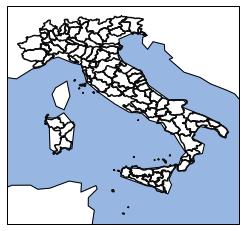

In [12]:
provinces = all_provinces[province_names]
print(provinces.names)
provinces.plot(add_label=False);

In [13]:
ds = xr.open_dataset('../data/interim/daily_environmental.nc').isel(expver=1)
provinces_mask = provinces.mask(ds['longitude'], ds['latitude'], wrap_lon=True)
provinces_ma = np.ma.masked_invalid(provinces_mask)

In [14]:
varnames = ['t2m', 'q2m', 'sp', 'tp', 'uvb', 'ssrd']
index = 0

country_list = []
province_list = []
date_list = []
variable_list = [[]]
confirmed_list = []
recovered_list = []
deaths_list = []

for v in range(len(varnames)-1):
    variable_list.append([])

region_names = rdf['Administrative Region'].unique()
for region in tqdm(region_names):
    # Aggregate Administrative Region mask from constituent Provinces
    tmp_province_names = rdf[rdf['Administrative Region'] == region]['Province'].unique()
    tmp_province_names = [province for province in all_provinces_names if province in tmp_province_names]

    region_mask = np.zeros_like(provinces_ma)
    for province in tmp_province_names:
        region_mask += (provinces_ma == provinces[province].number)
        
    for v, varname in enumerate(varnames):
        pmean = ds[varname].where(region_mask).mean(dim=['latitude', 'longitude']).compute()
        for date in ds['time']:
            variable_list[v].append(pmean.sel(time=date).values)
            if v==0:
                country_list.append(country)
                province_list.append(region) # Adm1 is actually not Italian "province"
                date_list.append(date.values)
                
                idx = (
                    (cdf['date'].astype("datetime64") == date.values) &
                    (cdf['adm1_name'] == region)
                )
                if idx.any():
                    confirmed_list.append(cdf[idx]['cum_confirmed_cases'].values.item())
                    deaths_list.append(cdf[idx]['cum_deaths'].values.item())
                    recovered_list.append(cdf[idx]['cum_recoveries'].values.item())
                else:
                    confirmed_list.append(np.nan)
                    deaths_list.append(np.nan)
                    recovered_list.append(np.nan)

  0%|          | 0/20 [00:00<?, ?it/s]/home/hdrake/.conda/envs/covid-weather/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
100%|██████████| 20/20 [04:29<00:00, 13.49s/it]


In [15]:
edf = pd.DataFrame({
    "Country/Region": country_list,
    "Province/State": province_list,
    "date": date_list,
    "Confirmed": np.array(confirmed_list),
    "Deaths": np.array(deaths_list),
    "Recovered": np.array(recovered_list)
})
vardict = {}
for v, varname in enumerate(varnames):
    edf[varname] = variable_list[v]
    
edf.to_csv(f"../data/processed/enviroment_provinces_{country}.csv")
edf.head()

,Country/Region,Province/State,date,Confirmed,Deaths,Recovered,t2m,q2m,sp,tp,uvb,ssrd
0,Italy,Abruzzo,2019-11-01,NaN,NaN,NaN,284.76053,0.008689065,92892.87,0.00036350748,16302.824,145568.52
1,Italy,Abruzzo,2019-11-02,NaN,NaN,NaN,285.755,0.00850245,92333.984,0.00013495643,32828.473,286161.44
2,Italy,Abruzzo,2019-11-03,NaN,NaN,NaN,287.93787,0.009405544,91464.6,0.00074310764,31303.18,263372.94
3,Italy,Abruzzo,2019-11-04,NaN,NaN,NaN,286.2538,0.007811783,91686.305,0.00010303236,41353.625,392041.62
4,Italy,Abruzzo,2019-11-05,NaN,NaN,NaN,288.33533,0.009230437,91724.02,0.0005646375,30907.041,263726.06


## South Korea
Coming soon.